# Pigments comparison for the studies of Iznik ceramics

Here is the Jupyter Notebook used for the comparison between the Iznik ceramics based on pigments studies.

After generating a database using creation_spectra_base.py, you can use it here by importing the ".txt" files in the data folder.
Then, you can use tools showed here for comparison.

## Import

Run it two time to get the interactive plot.

In [2]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import spectral.io.envi as envi
from spectral import imshow
import cv2
import pandas as pd
from scipy.stats.stats import pearsonr 
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from adjustText import adjust_text
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc


%matplotlib notebook

## Input for the pigments comparison


In [3]:
# Name of the database for reference spectra used
database_name = "iznik_pigments"

## Import the database of reference spectra

In [4]:
def csv2pigments(reader):
    pigments_dic = {}
    for row in reader:
        pigments_dic[row[0]]=[float(i) for i in row[1:]]

    pigments = np.array([pigments_dic[key] for key in pigments_dic.keys()])
    label = np.array([key for key in pigments_dic.keys()])
    return pigments, label


reader = csv.reader(open('data//databases//'+database_name+'.csv', mode='r'))

pigments, label = csv2pigments(reader)

bands = np.array(np.genfromtxt('bands.csv', delimiter=','))


<IPython.core.display.Javascript object>


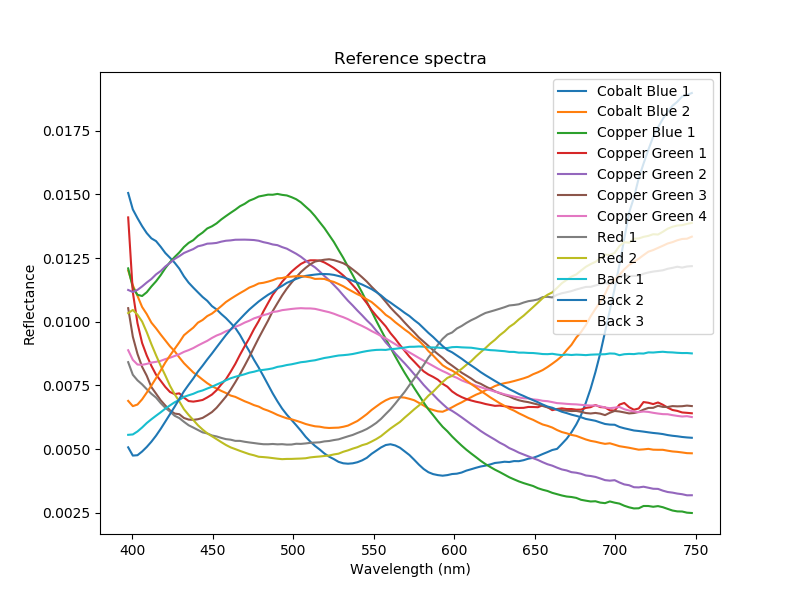

In [5]:
plt.figure(figsize=(8,6))

i = 0
for pig in pigments :
    plt.plot(bands[:120], pig, label = label[i])
    i = i +1
    
plt.legend(loc='upper right')
plt.title('Reference spectra')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.show()

## Import the data get from the Iznik hyperspectral images and generate the correlation dataframe

In [6]:
# Import the data (can be changed manually)
reader = csv.reader(open('data//pigments//background_spectra.csv', mode='r'))
background, label_background = csv2pigments(reader)

reader = csv.reader(open('data//pigments//red_spectra.csv', mode='r'))
red, label_red = csv2pigments(reader)

reader = csv.reader(open('data//pigments//green_spectra.csv', mode='r'))
green, label_green = csv2pigments(reader)

reader = csv.reader(open('data//pigments//copper_blue_spectra.csv', mode='r'))
copper_blue, label_copper_blue = csv2pigments(reader)

reader = csv.reader(open('data//pigments//cobalt_blue_spectra.csv', mode='r'))
cobalt_blue, label_cobalt_blue = csv2pigments(reader)

# Divide the pigments by the background in order
# to delete the colored glaze influence on the pigments
for i in range(len(label_red)):
    index = np.argwhere(label_background == label_red[i])[0,0]
    red[i] = np.divide(red[i], background[index])
    
for i in range(len(label_green)):
    index = np.argwhere(label_background == label_green[i])[0,0]
    green[i] = np.divide(green[i], background[index])
    
for i in range(len(label_copper_blue)):
    index = np.argwhere(label_background == label_copper_blue[i])[0,0]
    copper_blue[i] = np.divide(copper_blue[i], background[index])
    
for i in range(len(label_cobalt_blue)):
    index = np.argwhere(label_background == label_cobalt_blue[i])[0,0]
    cobalt_blue[i] = np.divide(cobalt_blue[i], background[index])

In [7]:
# Interactive plot of the pigments for each of the tiles
%matplotlib notebook

def interactive_plot(x, y_list, label, normalize='Yes'):
    fig, ax = plt.subplots()
    for i in range(len(y_list)):
        if normalize=='Yes':
            ax.plot(x, y_list[i]/sum(y_list[i]), label=label[i])
        else:
            ax.plot(x, y_list[i], label=label[i])

    ax.legend(loc='upper left', bbox_to_anchor=(-0.15, 2),
              ncol=5, borderaxespad=4, fontsize=7)
    fig.subplots_adjust(top=0.55)
    fig.suptitle('Right-click to hide all\nMiddle-click to show all',
                 va='top', size='large')

    leg = interactive_legend()
    return fig, ax, leg

def interactive_legend(ax=None):
    if ax is None:
        ax = plt.gca()
    if ax.legend_ is None:
        ax.legend()

    return InteractiveLegend(ax.get_legend())

class InteractiveLegend(object):
    def __init__(self, legend):
        self.legend = legend
        self.fig = legend.axes.figure

        self.lookup_artist, self.lookup_handle = self._build_lookups(legend)
        self._setup_connections()

        self.update()

    def _setup_connections(self):
        for artist in self.legend.texts + self.legend.legendHandles:
            artist.set_picker(10) # 10 points tolerance

        self.fig.canvas.mpl_connect('pick_event', self.on_pick)
        self.fig.canvas.mpl_connect('button_press_event', self.on_click)

    def _build_lookups(self, legend):
        labels = [t.get_text() for t in legend.texts]
        handles = legend.legendHandles
        label2handle = dict(zip(labels, handles))
        handle2text = dict(zip(handles, legend.texts))

        lookup_artist = {}
        lookup_handle = {}
        for artist in legend.axes.get_children():
            if artist.get_label() in labels:
                handle = label2handle[artist.get_label()]
                lookup_handle[artist] = handle
                lookup_artist[handle] = artist
                lookup_artist[handle2text[handle]] = artist

        lookup_handle.update(zip(handles, handles))
        lookup_handle.update(zip(legend.texts, handles))

        return lookup_artist, lookup_handle

    def on_pick(self, event):
        handle = event.artist
        if handle in self.lookup_artist:

            artist = self.lookup_artist[handle]
            artist.set_visible(not artist.get_visible())
            self.update()

    def on_click(self, event):
        if event.button == 3:
            visible = False
        elif event.button == 2:
            visible = True
        else:
            return

        for artist in self.lookup_artist.values():
            artist.set_visible(visible)
        self.update()

    def update(self):
        for artist in self.lookup_artist.values():
            handle = self.lookup_handle[artist]
            if artist.get_visible():
                handle.set_visible(True)
            else:
                handle.set_visible(False)
        self.fig.canvas.draw()

    def show(self):
        plt.show()

<IPython.core.display.Javascript object>


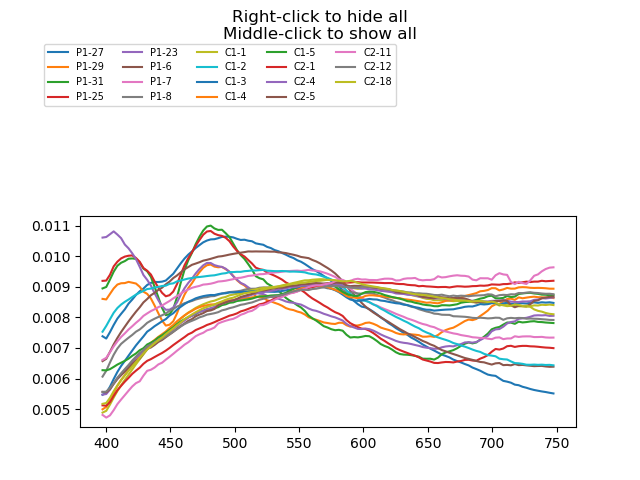

In [8]:
#------------------------------
# Choose manually a pigment between 'background',
#'red', 'green', 'copper_blue' and 'cobalt_blue'
pig = 'background'
#------------------------------

if pig == 'background':
    fig, ax, leg = interactive_plot(bands[:120],
                                    background[:,:120],
                                    label_background)
if pig == 'red':
    fig, ax, leg = interactive_plot(bands[:120],
                                    red[:,:120],
                                    label_red)
if pig == 'green':
    fig, ax, leg = interactive_plot(bands[:120],
                                    green[:,:120],
                                    label_green)
if pig == 'copper_blue':
    fig, ax, leg = interactive_plot(bands[:120],
                                    copper_blue[:,:120],
                                    label_copper_blue)
if pig == 'cobalt_blue':
    fig, ax, leg = interactive_plot(bands[:120],
                                    cobalt_blue[:,:120],
                                    label_cobalt_blue)
plt.show()


## Data processing : applying the Pearson correlation coefficient

In [30]:
def get_pearson(pigments, label_pigments, label_tile, tile, i):
    a = pigments
    if label_pigments[i] in label_tile :
        index = np.argwhere(label_tile == label_pigments[i])[0,0]
        b = tile[index, :120]
        x, y = pearsonr(a,b)
        return x
    else : 
        return 0
# Create a pandas DataFrame in order to deal with the correlation coefficients more efficiently
data = pd.DataFrame()
for i in range(len(label_background)):
    dic = {}
    dic['Name'] = label_background[i]
    
    # Cobalt blue 1
    dic[label[0]] = get_pearson(pigments[0, :120], label_background, label_cobalt_blue, cobalt_blue, i)
    
    # Cobalt blue 2
    dic[label[1]] = get_pearson(pigments[1, :120], label_background, label_cobalt_blue, cobalt_blue, i)
    
    # Copper blue 1
    dic[label[2]] = get_pearson(pigments[2, :120], label_background, label_copper_blue, copper_blue, i)
    
    # Copper green 1
    dic[label[3]] = get_pearson(pigments[3, :120], label_background, label_green, green, i)
    
    # Copper green 2
    dic[label[4]] = get_pearson(pigments[4, :120], label_background, label_green, green, i)
    
    # Copper green 3
    dic[label[5]] = get_pearson(pigments[5, :120], label_background, label_green, green, i)
    
    # Copper green 4
    dic[label[6]] = get_pearson(pigments[6, :120], label_background, label_green, green, i)
    
    # Red 1
    dic[label[7]] = get_pearson(pigments[7, :120], label_background, label_red, red, i)
    
    # Red 2
    dic[label[8]] = get_pearson(pigments[8, :120], label_background, label_red, red, i)
    
    # Background 1
    dic[label[9]] = get_pearson(pigments[9, :120], label_background, label_background, background, i)
    
    # Background 2
    dic[label[10]] = get_pearson(pigments[10, :120], label_background, label_background, background, i)
    
    # Background 3
    dic[label[11]] = get_pearson(pigments[11, :120], label_background, label_background, background, i)
    
    data = data.append(dic, ignore_index = True)

data = data.set_index('Name')

# Create an array for next studies and visualizations
list_data = np.array([data["Cobalt Blue 1"], data["Cobalt Blue 2"], data["Copper Blue 1"],
                 data['Copper Green 1'], data['Copper Green 2'], data['Copper Green 3'], data['Copper Green 4'],
                 data['Red 1'], data['Red 2'], data['Back 1'], data['Back 2'], data['Back 3']]).T

# Show the final dataframe
data

,Back 1,Back 2,Back 3,Cobalt Blue 1,Cobalt Blue 2,Copper Blue 1,Copper Green 1,Copper Green 2,Copper Green 3,Copper Green 4,Red 1,Red 2
Name,,,,,,,,,,,,
P1-27,-0.155510,0.897900,0.991694,0.980975,0.899085,0.000000,0.737593,0.952643,0.588329,0.948754,0.000000,0.000000
P1-29,-0.462619,0.210370,0.421958,0.951193,0.717361,0.000000,0.629082,0.989271,0.444309,0.865028,0.000000,0.000000
P1-31,-0.550151,0.444796,0.700549,0.965623,0.748391,0.000000,0.798476,0.956771,0.672105,0.975634,0.000000,0.000000
P1-25,-0.539072,0.603505,0.853899,0.986375,0.822539,0.000000,0.779505,0.922297,0.645642,0.956464,0.000000,0.000000
P1-23,-0.782267,0.211696,0.538816,0.957357,0.728431,0.000000,0.751394,0.936699,0.560751,0.897416,0.000000,0.000000
P1-6,0.021586,0.955078,0.979235,1.000000,0.845483,0.000000,0.784882,0.897692,0.634630,0.929584,0.000000,0.000000
P1-7,0.288610,0.976799,0.886842,0.980896,0.761638,0.000000,0.632403,0.994627,0.449559,0.882991,0.000000,0.000000
P1-8,0.714770,0.841879,0.574778,0.957507,0.758382,0.000000,0.662184,1.000000,0.508680,0.919371,0.000000,0.000000
C1-1,0.956320,0.530789,0.143865,0.988378,0.784300,0.982435,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## Plot the visualization 

### PCA Visualization

<IPython.core.display.Javascript object>


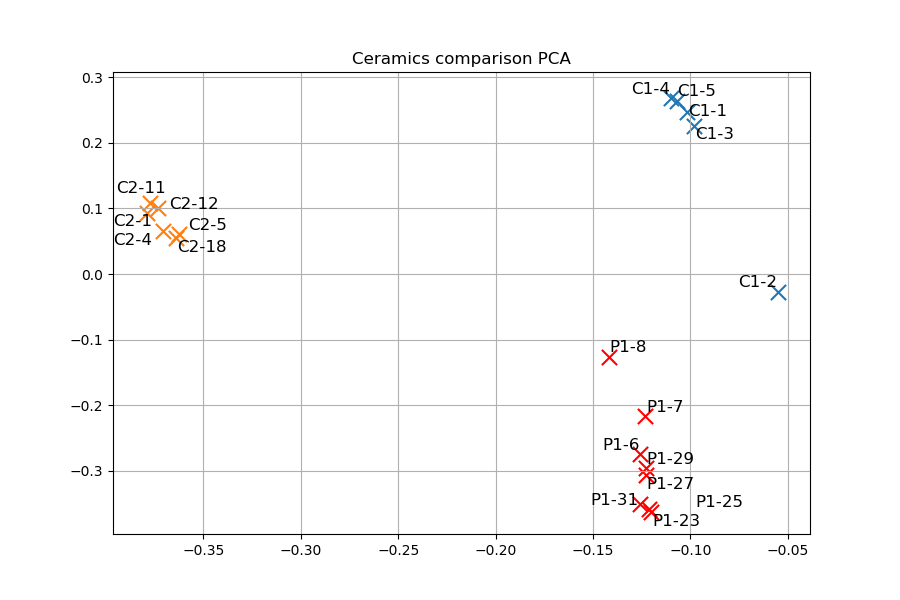

Text(0.5, 1.0, 'Ceramics comparison PCA')

In [31]:
# Kmeans to separate visually the differents tiles models 
#Kmeans
n_b = 3
kmeans_b = KMeans(n_clusters=n_b, random_state=10)
kmeans_b.fit(list_data)

# Execute the PCA
pca = PCA(n_components=2)
pca.fit(np.array(list_data).T)
PCA(n_components=2)

color = ['C0', 'C1', 'r']

# Visualization
plt.figure(figsize=(9,6))
plt.grid()
for i in range(len(pca.components_[0])):
    plt.scatter(pca.components_[0][i], pca.components_[1][i],
                marker = 'x', color = color[kmeans_b.labels_[i]], s = 120)

texts = [plt.text(pca.components_[0][i], pca.components_[1][i],
                  label_background[i], fontsize=12) for i in range(len(label_background))]
adjust_text(texts)
plt.title("Ceramics comparison PCA")

### Dendrogram from Agglomerative Clustering

<IPython.core.display.Javascript object>


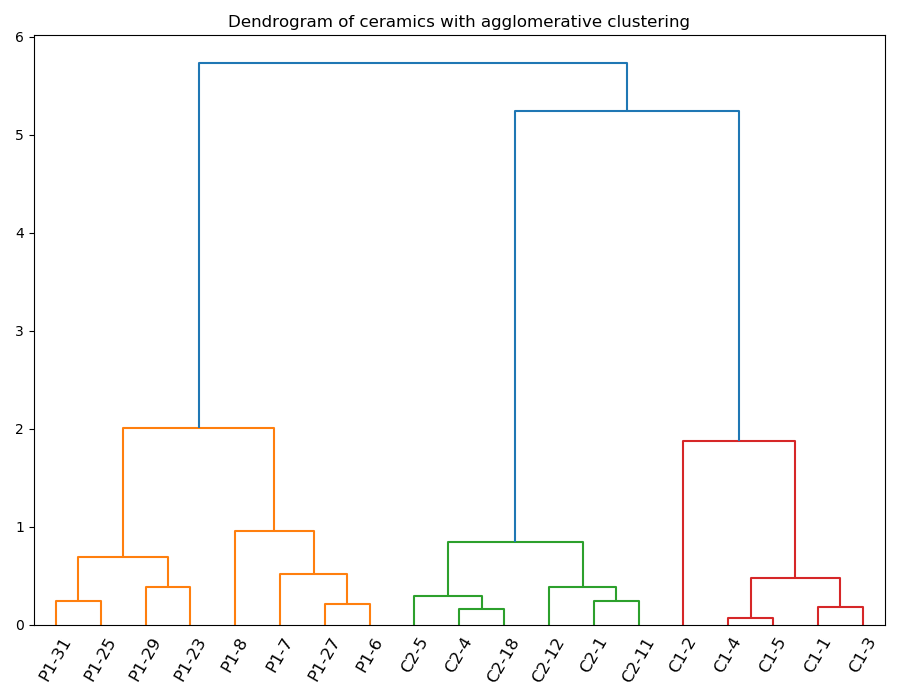

In [32]:
# AgglomerativeClustering
ward_b = AgglomerativeClustering(n_clusters=5)
ward_b.fit(list_data)

# Visualization
plt.figure(figsize=(9, 7))
dend = shc.dendrogram(shc.linkage(list_data, method='ward'), labels = label_background,
                          color_threshold = 3,
                          leaf_rotation= 60, leaf_font_size=12)
plt.title("Dendrogram of ceramics with agglomerative clustering")
plt.tight_layout()

### Confusion Matrix based on silhouette metrics

<IPython.core.display.Javascript object>


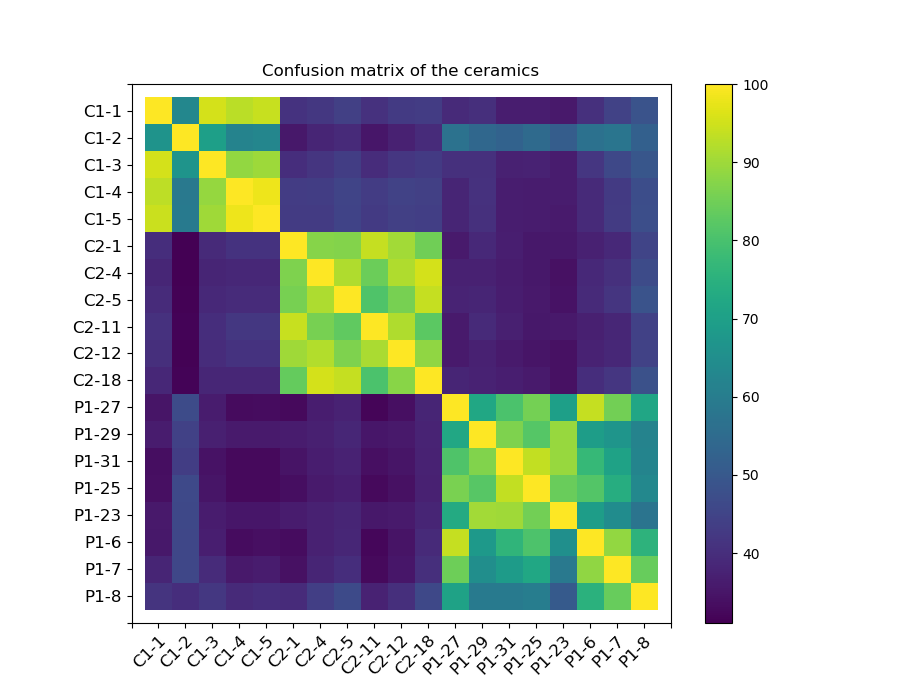

In [33]:
def silhouette_metrics_compar(X, sample_data, sample_label, data_compar, labels):
    # Determiner le coefficient de silhouette
    b_values = []
    for i in range(len(X)) :
        if (X[i] != sample_data).any() and(X[i] != data_compar).any() : 
            b_values.append(np.linalg.norm(sample_data-X[i]))
    a = np.linalg.norm(sample_data-data_compar)
    b = np.mean(b_values)
    return (b-a)/max(a,b)

# Kmeans to order the tiles in the confusion matrix
#Kmeans
n_b = 3
kmeans_b = KMeans(n_clusters=n_b, random_state=10)
kmeans_b.fit(list_data)


final_result = kmeans_b.labels_
label_new_order = ['']
data_new_order = []
results_new_order = []
for i in range(max(final_result)+1):
    for k in range(len(list_data)):
        if final_result[k] == i:
            label_new_order.append(label_background[k])
            data_new_order.append(list_data[k])
            results_new_order.append(final_result[k])
            
# Confusion matrix
conf_matrix = np.zeros((len(data_new_order), len(data_new_order)))
for x in range(len(data_new_order)):
    for y in range(len(data_new_order)):
        conf_matrix[x,y] = 100*(silhouette_metrics_compar(data_new_order, data_new_order[x],
                                                     results_new_order[x], data_new_order[y], results_new_order)+1)/2

# Visualization
fig, ax = plt.subplots(1,1, figsize=(9,7))
img = ax.imshow(conf_matrix)
fig.colorbar(img)
plt.title("Confusion matrix of the ceramics")
ax.set_yticks(np.arange(-1,len(label_new_order)))
ax.set_yticklabels(label_new_order)
ax.set_xticks(np.arange(-1,len(label_new_order)))
ax.set_xticklabels(label_new_order)
plt.setp(ax.get_yticklabels(), size=12)
plt.setp(ax.get_xticklabels(), size=12, rotation=45, ha="right",
         rotation_mode="anchor")
print('')

<IPython.core.display.Javascript object>


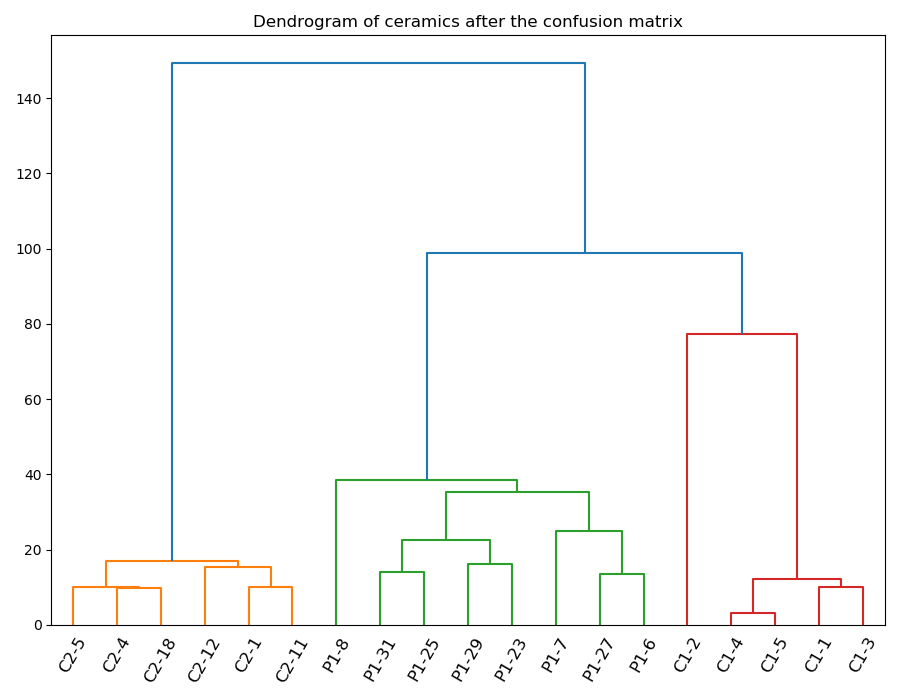

In [34]:
plt.figure(figsize=(9, 7))
Y = shc.distance.pdist(conf_matrix, metric='euclidean')
Z = shc.linkage(Y, method='single')
ax = shc.dendrogram(Z, show_contracted=True,
                          color_threshold = 90,
                          labels=label_new_order[1:],
                          leaf_rotation= 60, leaf_font_size=12)
plt.title("Dendrogram of ceramics after the confusion matrix")
plt.tight_layout()